#### Business Analytics FHDW 2025
## Aufgabe

Der Datensatz *a10.csv* enthält die monatlichen Absätze eines Medikamentes gegen Diabetes. Implementieren Sie ein geeignetes Modell zur Prädiktion der Absätze. Passen Sie zu diesem Zweck ggf. auch die Hilfsfunktionen zur Darstellung an.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import statsmodels.formula.api as smf
from statsmodels.tsa import tsatools
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics import tsaplots

def regressionSummary(y_true, y_predicted):
    y_true = np.asarray(y_true)
    y_predicted = np.asarray(y_predicted)
    y_residuals = y_true - y_predicted
    metrics = [
        ('Summe Abweichungen', sum(y_residuals)),
        ('Summe absolute Abweichungen', sum(abs(y_residuals))),
        ('Mittlerer Fehler', sum(y_residuals) / len(y_residuals)),
        ('Mittlerer absoluter Fehler', sum(abs(y_residuals)) / len(y_residuals)),
        ('Wurzel des durchschnittlichen Fehlerquadrats', np.sqrt(mean_squared_error(y_true, y_predicted)))
    ]
    if all(yt != 0 for yt in y_true):
        metrics.extend([
            ('Mittlerer prozentualer Fehler', 100 * sum(y_residuals / y_true) / len(y_residuals)),
            ('Mittlerer absoluter prozentualer Fehler', 100 * sum(abs(y_residuals / y_true) / len(y_residuals))),
        ])
    maxlength = max(len(m[0]) for m in metrics)
    fmt1 = f'{{:>{maxlength}}} : {{:.4f}}'    
    for metric, value in metrics:
        print(fmt1.format(metric, value))

def singleGraphLayout(ax, ylim, train_df, valid_df):
    ax.set_xlim('1991-7', '2008-6')
    ax.set_ylim(*ylim)
    ax.set_xlabel('Zeit')
    one_month = pd.Timedelta('31 days')
    
    xtrain = (min(train_df.index), max(train_df.index)-one_month)
    xvalid = (min(valid_df.index)+one_month, max(valid_df.index)-one_month)
    xtv = xtrain[1]+0.5*(xvalid[0]-xtrain[1])
    
    ypos = 0.9*ylim[1]+0.1*ylim[0]
    ax.add_line(plt.Line2D(xtrain, (ypos, ypos), color='black', linewidth=0.5))
    ax.add_line(plt.Line2D(xvalid, (ypos, ypos), color='black', linewidth=0.5))
    ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)
    
    ypos = 0.925*ylim[1]+0.075*ylim[0]
    ax.text('1991-7', ypos, 'Training')
    ax.text('2001-10', ypos, 'Validation')
    
def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0], [0, 35], train_df, valid_df)
    singleGraphLayout(axes[1], [-10, 10], train_df, valid_df)
    train_df.plot(y='sales', ax=axes[0], color='C0', linewidth=0.75)
    valid_df.plot(y='sales', ax=axes[0], color='C0', linestyle='dashed', linewidth=0.75)
    axes[1].axhline(y=0, xmin=0, xmax=1, color='black', linewidth=0.5)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Absatz')
    axes[1].set_ylabel('Vorhersagefehler')
    if axes[0].get_legend():
        axes[0].get_legend().remove()

Erst einmal einlesen und passend umwandeln.

In [2]:
sales_df = pd.read_csv('Daten/a10.csv')
sales_df

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
...,...,...
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510


In [3]:
sales_df['date'] = pd.to_datetime(sales_df.date, format='%Y-%m-%d')
sales_ts = pd.Series(sales_df.value.values, index=sales_df.date, name='sales')
sales_ts

date
1991-07-01     3.526591
1991-08-01     3.180891
1991-09-01     3.252221
1991-10-01     3.611003
1991-11-01     3.565869
                ...    
2008-02-01    21.654285
2008-03-01    18.264945
2008-04-01    23.107677
2008-05-01    22.912510
2008-06-01    19.431740
Name: sales, Length: 204, dtype: float64

Um einen Ansatz für passende Modelle zu finden, einfach darstellen.

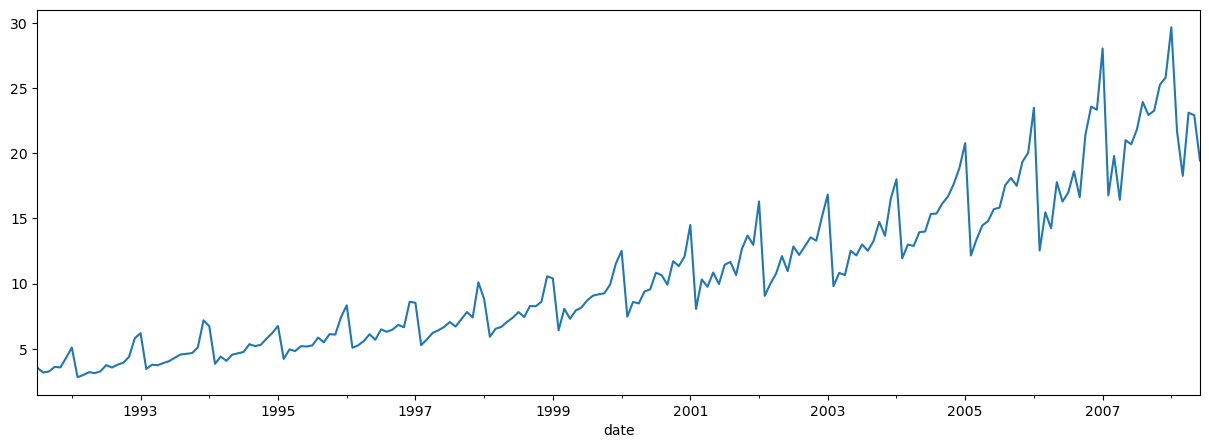

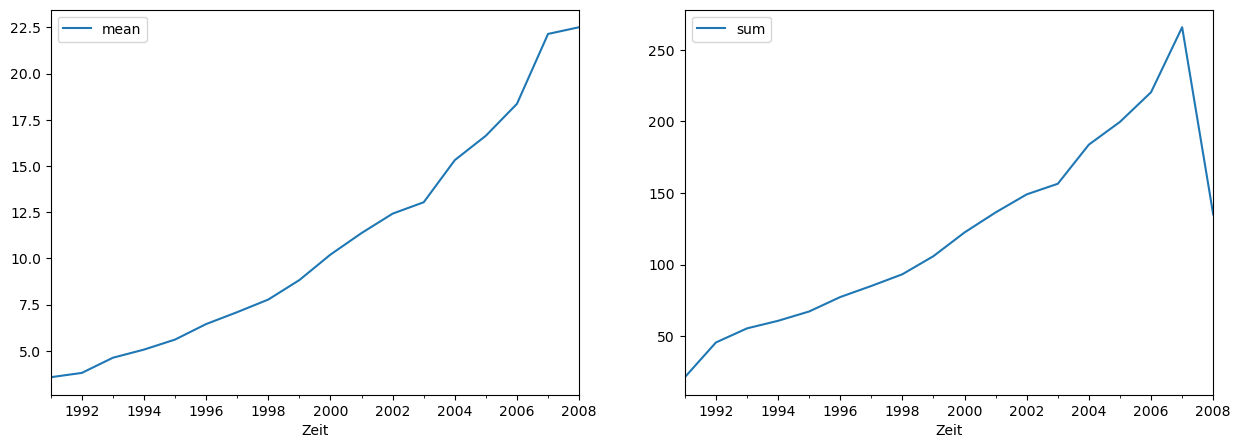

In [4]:
sales_ts.plot(figsize=(15,5))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sales_ts.resample('YE').agg(["mean"]).plot(xlabel="Zeit", ax=axes[0])
sales_ts.resample('YE').agg(["sum"]).plot(xlabel="Zeit", ax=axes[1])
plt.show()

Saisonalität ziemlich deutlich, Trend wirkt quadratisch (Steigung am Ende etwas höher).

In [5]:
sales_df = tsatools.add_trend(sales_ts, trend='ct')
sales_df['month'] = sales_df.index.month
sales_df

,sales,const,trend,month
date,,,,
1991-07-01,3.526591,1.0,1.0,7
1991-08-01,3.180891,1.0,2.0,8
1991-09-01,3.252221,1.0,3.0,9
1991-10-01,3.611003,1.0,4.0,10
1991-11-01,3.565869,1.0,5.0,11
...,...,...,...,...
2008-02-01,21.654285,1.0,200.0,2
2008-03-01,18.264945,1.0,201.0,3
2008-04-01,23.107677,1.0,202.0,4


In [6]:
n_train = 123
train_df = sales_df[:n_train]
valid_df = sales_df[n_train:]
sales_prediction_trend_season_add = smf.ols(formula='sales ~ trend + np.square(trend) + C(month)', data=train_df).fit()
predicted_trend_season_add = sales_prediction_trend_season_add.predict(valid_df)

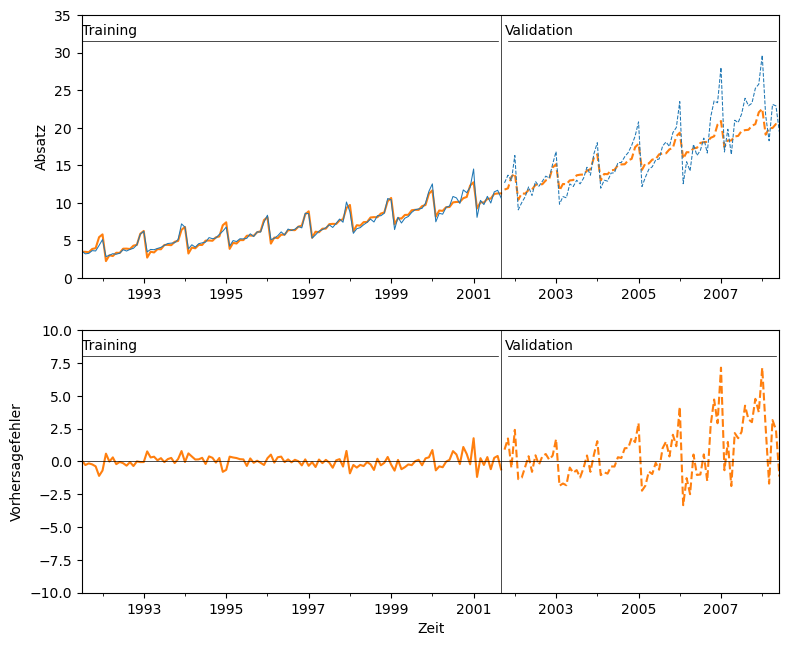

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))
sales_prediction_trend_season_add.predict(train_df).plot(ax=axes[0], color='C1')
sales_prediction_trend_season_add.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')

residual_train = train_df.sales - sales_prediction_trend_season_add.predict(train_df)
residual_train.plot(ax=axes[1], color='C1')
residual_valid = valid_df.sales - sales_prediction_trend_season_add.predict(valid_df)
residual_valid.plot(ax=axes[1], color='C1', linestyle='dashed')
graphLayout(axes, train_df, valid_df)
plt.show()

Saisonalität hier eher multiplikativ.

In [8]:
sales_prediction_trend_season_mul = smf.ols(formula='sales ~ trend + np.square(trend) * C(month)', data=train_df).fit()
predicted_trend_season_mul = sales_prediction_trend_season_mul.predict(valid_df)

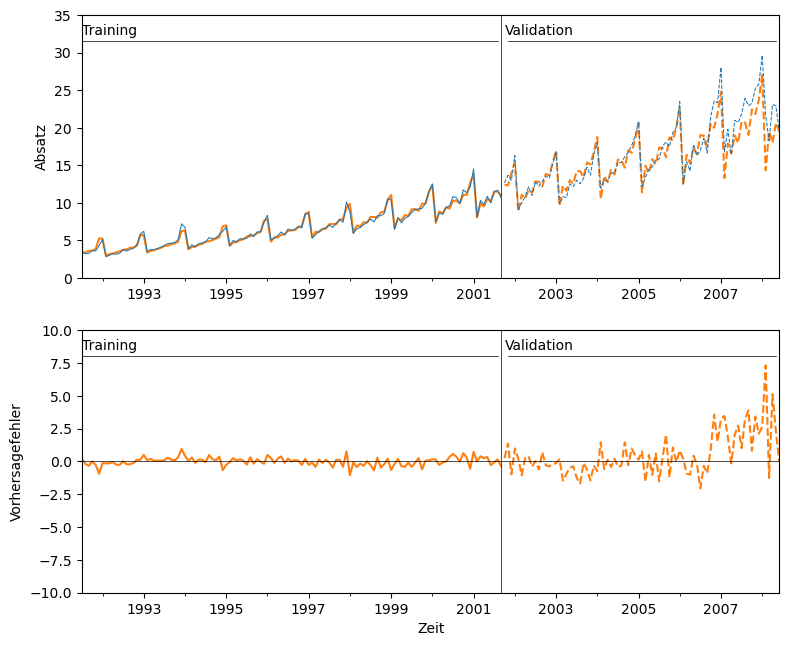

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))
sales_prediction_trend_season_mul.predict(train_df).plot(ax=axes[0], color='C1')
sales_prediction_trend_season_mul.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')

residual_train = train_df.sales - sales_prediction_trend_season_mul.predict(train_df)
residual_train.plot(ax=axes[1], color='C1')
residual_valid = valid_df.sales - sales_prediction_trend_season_mul.predict(valid_df)
residual_valid.plot(ax=axes[1], color='C1', linestyle='dashed')
graphLayout(axes, train_df, valid_df)
plt.show()

In [10]:
print('Quadratisches Modell mit additiver Saisonalität')
regressionSummary(valid_df.sales, predicted_trend_season_add)
print('')
print('Quadratisches Modell mit multiplikativer Saisonalität')
regressionSummary(valid_df.sales, predicted_trend_season_mul)

Quadratisches Modell mit additiver Saisonalität
                          Summe Abweichungen : 50.9102
                 Summe absolute Abweichungen : 131.7215
                            Mittlerer Fehler : 0.6285
                  Mittlerer absoluter Fehler : 1.6262
Wurzel des durchschnittlichen Fehlerquadrats : 2.1485
               Mittlerer prozentualer Fehler : 1.4492
     Mittlerer absoluter prozentualer Fehler : 9.1199

Quadratisches Modell mit multiplikativer Saisonalität
                          Summe Abweichungen : 39.5797
                 Summe absolute Abweichungen : 94.8617
                            Mittlerer Fehler : 0.4886
                  Mittlerer absoluter Fehler : 1.1711
Wurzel des durchschnittlichen Fehlerquadrats : 1.7080
               Mittlerer prozentualer Fehler : 1.6508
     Mittlerer absoluter prozentualer Fehler : 6.5439
